**Meal Detection using auto regression bases SARIMA model**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/MC_Project/

/content/gdrive/My Drive/MC_Project


#### Import necessary libraries

In [ ]:
import warnings
import itertools
import numpy as np
import os
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

In [ ]:
data = pd.read_csv(os.getcwd() + '/Final_Data.csv')
data = data['Value CGM']


#### Plotting Autocorrelation and Partial Autocorrelation 

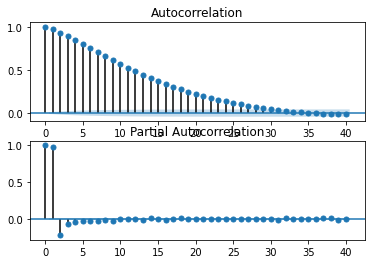

In [ ]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax[1])
plt.show()

#### Calculate relative quality of statistical models for a given data set

In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:461399.67425100674
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:429601.89812909334
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:413493.1910130037
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:388958.4182986225
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:386647.27245840244
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:378744.91831754596
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:418421.468058707
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:388804.00855105853


#### Dividing data into train and test data set and fit SARIMA model for prediction using walk forward validation technique

In [ ]:
def train_model(data):
    model = sm.tsa.statespace.SARIMAX(data,
                                order=(1 ,1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit();
    return model;

In [ ]:
train_size = int(len(data)*0.8);
train, test = data[:train_size],data[train_size:]
model= train_model(data)
print (model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          Value CGM   No. Observations:                35100
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood             -142192.158
Date:                            Sat, 05 Dec 2020   AIC                         284394.316
Time:                                    23:57:15   BIC                         284436.643
Sample:                                         0   HQIC                        284407.797
                                          - 35100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4133      0.015     27.729      0.000       0.384       0.443
ma.L1         -0.2177      0.015   

In [ ]:
predictions = model.predict(start=train_size,end=(train_size-1)+len(test));
ground_truth = test
res = pd.DataFrame();
res['Predictions'] = predictions
res['Actual'] = ground_truth
res

,Predictions,Actual
28080,89.901086,89.0
28081,88.220428,84.0
28082,82.727241,81.0
28083,80.267290,66.0
28084,62.983413,57.0
...,...,...
35095,313.897796,314.0
35096,313.632310,314.0
35097,314.066611,314.0
35098,313.995955,314.0


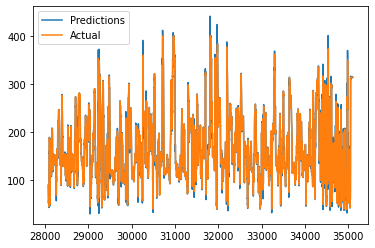

In [ ]:
res.plot()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
def forecast_accuracy(forecast, actual):         
    mae =  mean_absolute_error(actual, forecast)   
    mse = mean_squared_error(actual, forecast)
    rmse = sqrt(mse)         
    return({
        'mae':mae,
        'mse':mse,
        'rmse':rmse
    })

####Mean Absolute Error, Mean Squared Error, Root Mean Squared Error (Accuracy Measurement)

In [ ]:
error = forecast_accuracy(predictions,ground_truth)
print (error)

{'mae': 6.548922854550947, 'mse': 256.12495975597153, 'rmse': 16.00390451596021}


#### Predict next 1 hour of data to get intuition of meal event.

In [ ]:
predictions = model.predict(train_size,(train_size-1)+12);
grount_truth = test.head(12);
res = pd.DataFrame();
res['Predictions'] = predictions
res['Actual'] = grount_truth
res

,Predictions,Actual
28080,89.901086,89.0
28081,88.220428,84.0
28082,82.727241,81.0
28083,80.267290,66.0
28084,62.983413,57.0
28085,54.660288,53.0
28086,51.726154,57.0
28087,57.565304,57.0
28088,57.037321,58.0
28089,58.290092,58.0


In [ ]:
error = forecast_accuracy(predictions,grount_truth)
print (error)

{'mae': 3.0843077787082316, 'mse': 24.474699713825007, 'rmse': 4.947191093320027}


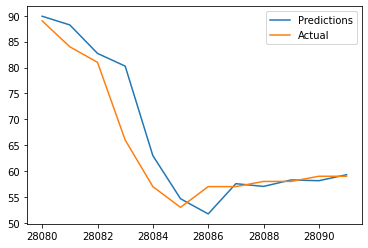

In [ ]:
res.plot()

In [ ]:
d = pd.read_csv(os.getcwd() + '/Final_Data.csv')

bolus = d['Value Bolus']
threshold = np.mean(data[train_size:])*0.4

b_count = 0
idx_g = []
for i in range(train_size, (train_size-1)+len(test)):
  if bolus[i] > 1.0:
    b_count += 1
    idx_g.append(i)

count = 0
idx = []
for i in range(train_size, (train_size-1)+len(test)):
  if abs(res['Predictions'][i] - res['Actual'][i]) > threshold:
    count += 1
    idx.append(i)

print("Test Acc (%):", count/b_count*100)

Test Acc (%): 61.15702479338842
